## Linear Regression Model

- 이번 실습는 linear regression model을 직접 구현하여 mini-batch stochastic gradient descent 방법을 이용해서 model을 학습시켜보겠습니다.


In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

### Numpy & PyTorch
- y = Xw + b 연산을 numpy와 pytorch에서 각각 계산해보고 유사성을 확인합니다.

In [2]:
# numpy 

x1 = np.array([1.,0,0])
x2 = np.array([0,2.0,0])

X = np.zeros((2,3))
X[0,:] = x1
X[1,:] = x2

w = np.array([2.,4,8])
b = np.array([1.])

y = np.matmul(X,w)+b 

print('X:',X)
print('w:',w)
print('b:',b)
print('y:',y)

X: [[1. 0. 0.]
 [0. 2. 0.]]
w: [2. 4. 8.]
b: [1.]
y: [3. 9.]


In [3]:
# pytorch

x1 = torch.tensor([1.,0,0])
x2 = torch.tensor([0,2.,0])

X = torch.zeros((2,3))
X[0,:] = x1
X[1,:] = x2

w = torch.tensor([2.,4.,8.])
b = torch.tensor(1.)

y = torch.matmul(X,w) + b

print('X:',X)
print('w:',w)
print('b:',b)
print('y:',y)


X: tensor([[1., 0., 0.],
        [0., 2., 0.]])
w: tensor([2., 4., 8.])
b: tensor(1.)
y: tensor([3., 9.])


- numpy array와 pytorch tensor 사이의 연산을 확인합니다.
- a+b는 안되는데 b+a는 되는 이유는 무엇일까요?

In [4]:
a = np.array([1,2,3.])
b = torch.tensor([1,2,3.])

#print(a+b)
#print(a-b)
print(a*b)

TypeError: unsupported operand type(s) for *: 'numpy.ndarray' and 'Tensor'

In [5]:
a = np.array([1,2,3.])
b = torch.tensor([1,2,3.])

print(b+a)
print(b-a)
print(b*a)

tensor([2., 4., 6.], dtype=torch.float64)
tensor([0., 0., 0.], dtype=torch.float64)
tensor([1., 4., 9.], dtype=torch.float64)


### Defining Linear Regression Model
- Matrix X는 각 row에 각각의 example이 가지고 있는 input feature들을 포함합니다.
- vector w는 각각의 feature에 해당하는 weight입니다.
- b는 bias로 모든 feature가 0일 때의 출력값입니다.
- w와 b는 우리가 학습을 시켜야 되는 파라미터들이기 때문에 requires_grad = True 를 포함시켜야 합니다. 
- pytorch에서는 requires_grad = True인 tensor들에 대해 자동으로 gradient를 계산할 수 있습니다. 

In [6]:
# linear regression model y = Xw + b
def linreg(X, w, b):
    return torch.matmul(X,w) + b

In [7]:
X = torch.eye(3)
w = torch.normal(0,0.01,size=(3,1),requires_grad = True)
#w = torch.tensor([1.,1,1],requires_grad = True)
b = torch.zeros(1,requires_grad = True)

print("X:",X)
print("w:",w)
print("b:",b)

X: tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
w: tensor([[ 0.0123],
        [ 0.0120],
        [-0.0018]], requires_grad=True)
b: tensor([0.], requires_grad=True)


In [8]:
y = linreg(X,w,b)
print("y:",y)

y: tensor([[ 0.0123],
        [ 0.0120],
        [-0.0018]], grad_fn=<AddBackward0>)


### Defining Squared Loss
- tensor의 연산에서 tensor의 shape를 맞추는 것은 매우 중요합니다.
- tensor의 shape가 맞지 않는 경우 임의로 broadcasting이 진행되어, 의도하지 않은 결과를 얻을 수 있습니다.

In [9]:
y_hat = torch.normal(0,0.1,size=(3,1))
y = torch.tensor([1.,2,3])

print((y-y_hat)**2)

tensor([[1.1380, 4.2715, 9.4051],
        [1.0535, 4.1063, 9.1591],
        [0.6351, 3.2289, 7.8228]])


In [10]:
y_hat = torch.normal(0,0.1,size=(3,1))
y = torch.tensor([1.,2,3],)


print( (y_hat-y.reshape(y_hat.shape))**2 /2)

tensor([[0.5872],
        [2.1540],
        [4.6670]])


In [11]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

In [12]:
squared_loss(y_hat,y)

tensor([[0.5872],
        [2.1540],
        [4.6670]])

- 정의한 loss function을 이용하여 w, b에 대한 gradient를 계산합니다.

In [13]:
y = torch.tensor([1.,2,3]) # label (ground truth)
X = torch.eye(3)
w = torch.tensor([1.,1,1],requires_grad = True)
b = torch.zeros(1,requires_grad = True)

print('# initial parameters')
print(w,b)
print('# initial gradients: None')
print(w.grad, b.grad)

y_hat = linreg(X,w,b)
print('# first prediction using initial parameters')
print(y_hat)

l = squared_loss(y_hat, y)
l.sum().backward()
print('# calculated loss')
print(l.sum())

print('# calculated gradients using the loss')
print(w.grad, b.grad)


# initial parameters
tensor([1., 1., 1.], requires_grad=True) tensor([0.], requires_grad=True)
# initial gradients: None
None None
# first prediction using initial parameters
tensor([1., 1., 1.], grad_fn=<AddBackward0>)
# calculated loss
tensor(2.5000, grad_fn=<SumBackward0>)
# calculated gradients using the loss
tensor([ 0., -1., -2.]) tensor([-3.])


- 계산된 gradients를 이용해 파라미터를 새로 업데이트 합니다.
- 파라미터를 업데이트한 후에는 각각의 파라미터의 gradient를 다시 초기화 해주어야 합니다.

In [14]:
lr = 1
batch_size = 3
print([w,b])
print([w.grad,b.grad])
with torch.no_grad():
    w -= lr * w.grad/batch_size # w = w - lr*w.grad 
    b -= lr * b.grad/batch_size # b = b - lr*b.grad
    w.grad.zero_()
    b.grad.zero_()
print([w,b])
print([w.grad,b.grad])

[tensor([1., 1., 1.], requires_grad=True), tensor([0.], requires_grad=True)]
[tensor([ 0., -1., -2.]), tensor([-3.])]
[tensor([1.0000, 1.3333, 1.6667], requires_grad=True), tensor([1.], requires_grad=True)]
[tensor([0., 0., 0.]), tensor([0.])]


### Defining minibatch stochastic gradient descent

In [15]:
def sgd(params, lr, batch_size):  
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad/batch_size
            param.grad.zero_()

- Linear regression model 학습을 위한 model architecture, loss function, optimization algorithm이 모두 준비가 되었습니다.
- 3개의 example로 구성된 간단한 데이터를 이용해 학습을 진행하는 과정을 살펴 봅니다.

In [16]:
lr = 1
batch_size = 3

y = torch.tensor([1.,2,3]) # label (ground truth)
X = torch.eye(3)
w = torch.tensor([1.,1,1],requires_grad = True)
b = torch.zeros(1,requires_grad = True)

print('# initial parameters')
print(w,b)

# 1st iteration
y_hat = linreg(X,w,b)
print('\n')
print('## first prediction using initial parameters ##')
print(y_hat)

l = squared_loss(y_hat, y)
l.sum().backward()
sgd([w,b],lr,batch_size)
print('# updated parameters')
print(w, b)

# 2nd iteration
y_hat = linreg(X,w,b)
print('\n')
print('## second prediction using the updated parameters ##')
print(y_hat)

l = squared_loss(y_hat, y)
l.sum().backward()
sgd([w,b],lr,batch_size)
print('# updated parameters')
print(w, b)


# 3rd iteration
y_hat = linreg(X,w,b)
print('\n')
print('## third prediction using the updated parameters ##')
print(y_hat)

l = squared_loss(y_hat, y)
l.sum().backward()
sgd([w,b],lr,batch_size)
print('# updated parameters')
print(w, b)


# 4th iteration
y_hat = linreg(X,w,b)
print('\n')
print('## fourth prediction using the updated parameters ##')
print(y_hat)

l = squared_loss(y_hat, y)
l.sum().backward()
sgd([w,b],lr,batch_size)
print('# updated parameters')
print(w, b)


# initial parameters
tensor([1., 1., 1.], requires_grad=True) tensor([0.], requires_grad=True)


## first prediction using initial parameters ##
tensor([1., 1., 1.], grad_fn=<AddBackward0>)
# updated parameters
tensor([1.0000, 1.3333, 1.6667], requires_grad=True) tensor([1.], requires_grad=True)


## second prediction using the updated parameters ##
tensor([2.0000, 2.3333, 2.6667], grad_fn=<AddBackward0>)
# updated parameters
tensor([0.6667, 1.2222, 1.7778], requires_grad=True) tensor([0.6667], requires_grad=True)


## third prediction using the updated parameters ##
tensor([1.3333, 1.8889, 2.4444], grad_fn=<AddBackward0>)
# updated parameters
tensor([0.5556, 1.2593, 1.9630], requires_grad=True) tensor([0.7778], requires_grad=True)


## fourth prediction using the updated parameters ##
tensor([1.3333, 2.0370, 2.7407], grad_fn=<AddBackward0>)
# updated parameters
tensor([0.4444, 1.2469, 2.0494], requires_grad=True) tensor([0.7407], requires_grad=True)


### Generating Synthetic Data & Defining Data Loader
- 실제로 linear 관계를 가지는 input feature와 label을 시뮬레이션을 통해 생성합니다.
- 현실적인 상황에 좀 더 가깝도록 data에 노이즈를 추가하여 봅니다.
- minibatch size를 기반으로 랜덤으로 데이터를 추출하여 가져올 수 있는 data loader를 정의합니다.

In [17]:
X = torch.normal(0,2,(1000,2))
y = torch.matmul(X,torch.tensor([3.,4]))+5 # y = 3x1 + 4x2 + 5
y += torch.normal(0,0.01,y.shape)

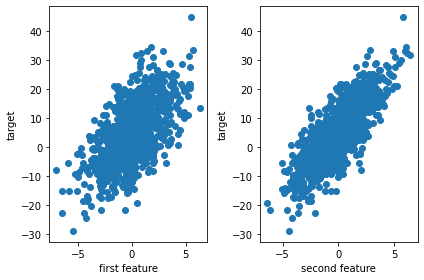

In [18]:
plt.subplot(121)
plt.scatter(X[:,0],y)
plt.xlabel('first feature')
plt.ylabel('target')
plt.subplot(122)
plt.scatter(X[:,1],y)
plt.xlabel('second feature')
plt.ylabel('target')
plt.tight_layout()
plt.show()

In [19]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [20]:
batch_size=4
for X_tr, y_tr in data_iter(batch_size,X,y):
    print(X_tr.shape)
    print(y_tr.shape)
    break

torch.Size([4, 2])
torch.Size([4])


### Train a Model
- 모델의 파라미터 w, b 를 모두 0으로 초기화하고, 하이퍼파라미터들(num_epochs, batch_size, learning rate)을 정해 줍니다.
- 미리 정의한 network architecture, loss function을 가져오고 학습을 진행해 봅니다.

In [21]:
w = torch.tensor([0.,0.],requires_grad = True)
b = torch.zeros(1,requires_grad = True)
num_epochs = 3
batch_size = 16
lr = 0.1
net = linreg
loss = squared_loss

w = torch.tensor([1.,1.],requires_grad = True)
b = torch.zeros(1.,requires_grad = True)

In [22]:

for epoch in range(num_epochs):
    for X_tr, y_tr in data_iter(batch_size, X, y):
        l = loss(net(X_tr, w, b), y_tr)  # Minibatch loss in `X_tr` and `y_tr`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(X, w, b), y)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')


epoch 1, loss 0.000071
epoch 2, loss 0.000053
epoch 3, loss 0.000052


- 학습된 모델의 파라미터가 우리가 만든 데이터의 w1=3, w2=4, b=5와 맞는 지 확인해 봅시다.

In [23]:
print(w[0],w[1],b)

tensor(2.9999, grad_fn=<SelectBackward0>) tensor(4.0002, grad_fn=<SelectBackward0>) tensor([5.0000], requires_grad=True)
